# Temporal GFP

In [1]:
import pandas as pd
import numpy as np
import math
import networkx as nx
import statsmodels.api as sm
from datetime import datetime
import sqlite3
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

from utils import ROOTPATH, build_df_year, generate_index
from backbone import disparity_filter

## load data

In [2]:
dfall = pd.DataFrame()
for y in range(2012, 2016):  # will change to (2012, 2016 later)
    dfyear = build_df_year(y, with_text=False, with_time=True, filter_null=True)
    dfall = dfall.append(dfyear)

building base dataframe for year 2012...
- fetching submissions for year 2012
- fetching comments for year 2012
building base dataframe for year 2013...
- fetching submissions for year 2013
- fetching comments for year 2013
building base dataframe for year 2014...
- fetching submissions for year 2014
- fetching comments for year 2014
building base dataframe for year 2015...
- fetching submissions for year 2015
- fetching comments for year 2015


## filter data

In [3]:
# # filter out inactive users
# aggr_func = {
#     "subreddit": lambda x: set(x),
#     "submission_id": lambda x: set(x),
# #     "comment_id": lambda x: set(x),
#     "uniq_id":lambda x: list(x)
#             }

# dfall["uniq_id"] = range(0, len(dfall))
# user_aggr = dfall.groupby("author").agg(aggr_func)  # this should take a while
# user_aggr = user_aggr.reset_index()
# user_aggr["n_subr"] = user_aggr["subreddit"].map(lambda x: len(x))
# user_aggr["n_subm"] = user_aggr["submission_id"].map(lambda x: len(x))
# # user_aggr["n_comm"] = user_aggr["submission_id"].map(lambda x: len(set(x)))
# user_aggr["n_post"] = user_aggr["uniq_id"].map(lambda x: len(x))

# user_select1 = user_aggr[(user_aggr["n_subm"]>=2)&(user_aggr["n_post"]>=10)][["author"]]
# user_select2 = user_aggr[(user_aggr["n_subm"]>=2)&(user_aggr["n_post"]>=20)][["author"]]
# user_select3 = user_aggr[(user_aggr["n_subm"]>=2)&(user_aggr["n_post"]>=50)][["author"]]
# user_select4 = user_aggr[(user_aggr["n_subm"]>=5)&(user_aggr["n_post"]>=100)][["author"]]
# user_select1.to_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS2_10.csv", index=False)
# user_select2.to_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS2_20.csv", index=False)
# user_select3.to_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS2_50.csv", index=False)
# user_select4.to_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS5_100.csv", index=False)

In [4]:
user_select = pd.read_csv(ROOTPATH + "indx/ACTIVEUSERS_ALLYEARS2_50.csv")
USERS = user_select["author"].tolist()
dfall = dfall[dfall["author"].isin(USERS)]

# generate user index
user2index = index2user = {}
for i,u in enumerate(USERS):
    user2index[u] = i
    index2user[i] = u

In [5]:
aggr_func = {"author": lambda x: set(x)}
groupby_subm = dfall[["submission_id","author"]].groupby("submission_id").agg(aggr_func).reset_index()
SUBM_USERSET = groupby_subm.set_index("submission_id").to_dict()["author"]

# later only focus on multi-user submissions
groupby_subm["n_author"] = groupby_subm["author"].map(lambda x: len(x))
SU_SUBM = groupby_subm[groupby_subm["n_author"]==1]["submission_id"].tolist()
df_multiuser_subm = dfall[~dfall["submission_id"].isin(SU_SUBM)]

## build temporal dataframe

In [6]:
# start and end time of submissions
aggr_func = {"created_utc": [np.min, np.max]}
SUBM_TIME = dfall[["submission_id","created_utc"]].groupby("submission_id").agg(aggr_func)
SUBM_TIME.columns = SUBM_TIME.columns.droplevel(0)
SUBM_TIME_DICT = SUBM_TIME.to_dict()

In [7]:
TOX_DF = dfall[["author","created_utc","toxicity"]].sort_values(by=["author", "created_utc"])
TOX_DF = TOX_DF.reset_index().drop(columns=["index"])
aggr_func = {"created_utc":lambda x: list(x), "toxicity":lambda x: list(x)}
TOX_DF_AGGR = TOX_DF.groupby("author").agg(aggr_func)
TOX_DICT = TOX_DF_AGGR.to_dict()

In [8]:
def calculate_temp_toxicity(user, start, end):
    times = TOX_DICT["created_utc"][user]
    scores = TOX_DICT["toxicity"][user]
    tox_ls = []
    for (t,s) in zip(times, scores):
        if t>=start and t<=end and str(s)!="nan":
            tox_ls.append(s)
    return np.mean(tox_ls)

# def calculate_temp_toxicity(user, start, end):  --> df indexing is too slow
#     df = TOX_DF[(TOX_DF["author"]==user)&(TOX_DF["created_utc"]>=start)&(TOX_DF["created_utc"]<=end)]
#     if len(df)>0: avg_tox = np.mean(df["toxicity"])
#     else: avg_tox = np.NaN
#     return avg_tox

In [11]:
dfall["uniq_id"] = range(0, len(dfall))
dfall = dfall.sort_values(by=["author", "created_utc"])
UNIQ2TIME = dfall[["uniq_id", "created_utc"]].set_index("uniq_id").to_dict()["created_utc"]

In [13]:
aggr_func = {"uniq_id": lambda x: list(x)}
groupby_user = dfall[["uniq_id","author"]].groupby("author").agg(aggr_func)
USER_POST_DICT = groupby_user.to_dict()["uniq_id"]

In [14]:
uniq2subm = dfall[["uniq_id","submission_id"]].set_index("uniq_id").to_dict()["submission_id"]

In [16]:
step = 0.1
temp_me_tox = np.zeros((len(USERS), int(1/step)))
temp_env_tox = np.zeros((len(USERS), int(1/step)))
temp_gfp = np.zeros((len(USERS), int(1/step)))

for j, (u, all_posts) in enumerate(USER_POST_DICT.items()):
    if j%10==0: print("progress:", j/len(USERS))
#     print("user:", j, u)
    for i in range(int(1/step)):
        
#         print("computing window...")
        post_window = all_posts[math.floor(step*i*len(all_posts)):math.floor(step*(i+1)*len(all_posts))]
        subm_window = list(set([uniq2subm[x] for x in post_window]))
        start_time = SUBM_TIME_DICT["amin"][subm_window[0]]
        end_time = UNIQ2TIME[post_window[-1]]
        
#         print("getting neighbors...")
        temp_neighbors = []
        for subm in subm_window:
            temp_neighbors += SUBM_USERSET[subm]
        temp_neighbors = set(temp_neighbors)

#         print("calculating toxicity...")
        my_tox = calculate_temp_toxicity(u, start_time, end_time)
        env_tox = []
        for nei in temp_neighbors:
            their_tox = calculate_temp_toxicity(nei, start_time, end_time)
            if str(their_tox)!="nan":
                env_tox.append(their_tox)
        env_tox = np.mean(env_tox)
        
        temp_me_tox[user2index[u],i] = my_tox
        temp_env_tox[user2index[u],i] = env_tox
        if env_tox > my_tox:
            temp_gfp[user2index[u],i] = 1  

progress: 0.0
progress: 0.00016661668166216803
progress: 0.00033323336332433606
progress: 0.000499850044986504
progress: 0.0006664667266486721
progress: 0.0008330834083108401
progress: 0.000999700089973008
progress: 0.001166316771635176
progress: 0.0013329334532973442
progress: 0.0014995501349595122
progress: 0.0016661668166216802
progress: 0.0018327834982838481
progress: 0.001999400179946016
progress: 0.0021660168616081843
progress: 0.002332633543270352
progress: 0.0024992502249325203
progress: 0.0026658669065946885
progress: 0.002832483588256856
progress: 0.0029991002699190244
progress: 0.003165716951581192
progress: 0.0033323336332433603
progress: 0.0034989503149055285
progress: 0.0036655669965676963
progress: 0.0038321836782298645
progress: 0.003998800359892032
progress: 0.0041654170415542004
progress: 0.004332033723216369
progress: 0.004498650404878537
progress: 0.004665267086540704
progress: 0.004831883768202872
progress: 0.0049985004498650405
progress: 0.005165117131527209
progr

progress: 0.04465327068546103
progress: 0.044819887367123196
progress: 0.04498650404878536
progress: 0.045153120730447534
progress: 0.0453197374121097
progress: 0.04548635409377187
progress: 0.04565297077543404
progress: 0.0458195874570962
progress: 0.045986204138758376
progress: 0.04615282082042054
progress: 0.04631943750208271
progress: 0.04648605418374488
progress: 0.046652670865407045
progress: 0.04681928754706921
progress: 0.04698590422873138
progress: 0.04715252091039355
progress: 0.047319137592055714
progress: 0.04748575427371789
progress: 0.04765237095538005
progress: 0.04781898763704222
progress: 0.04798560431870439
progress: 0.048152221000366556
progress: 0.04831883768202872
progress: 0.048485454363690894
progress: 0.04865207104535306
progress: 0.048818687727015225
progress: 0.0489853044086774
progress: 0.04915192109033956
progress: 0.049318537772001736
progress: 0.0494851544536639
progress: 0.04965177113532607
progress: 0.04981838781698824
progress: 0.049985004498650405
prog

progress: 0.09030624146089507
progress: 0.09047285814255723
progress: 0.0906394748242194
progress: 0.09080609150588156
progress: 0.09097270818754374
progress: 0.09113932486920591
progress: 0.09130594155086807
progress: 0.09147255823253024
progress: 0.0916391749141924
progress: 0.09180579159585457
progress: 0.09197240827751675
progress: 0.09213902495917892
progress: 0.09230564164084108
progress: 0.09247225832250325
progress: 0.09263887500416541
progress: 0.09280549168582758
progress: 0.09297210836748976
progress: 0.09313872504915192
progress: 0.09330534173081409
progress: 0.09347195841247626
progress: 0.09363857509413842
progress: 0.09380519177580059
progress: 0.09397180845746277
progress: 0.09413842513912493
progress: 0.0943050418207871
progress: 0.09447165850244926
progress: 0.09463827518411143
progress: 0.09480489186577361
progress: 0.09497150854743577
progress: 0.09513812522909794
progress: 0.0953047419107601
progress: 0.09547135859242227
progress: 0.09563797527408444
progress: 0.09

progress: 0.13612582891799127
progress: 0.13629244559965345
progress: 0.1364590622813156
progress: 0.13662567896297778
progress: 0.13679229564463993
progress: 0.1369589123263021
progress: 0.13712552900796426
progress: 0.13729214568962644
progress: 0.13745876237128862
progress: 0.13762537905295077
progress: 0.13779199573461295
progress: 0.1379586124162751
progress: 0.13812522909793729
progress: 0.13829184577959946
progress: 0.13845846246126162
progress: 0.1386250791429238
progress: 0.13879169582458595
progress: 0.13895831250624813
progress: 0.1391249291879103
progress: 0.13929154586957246
progress: 0.13945816255123464
progress: 0.1396247792328968
progress: 0.13979139591455897
progress: 0.13995801259622112
progress: 0.1401246292778833
progress: 0.14029124595954548
progress: 0.14045786264120763
progress: 0.1406244793228698
progress: 0.14079109600453196
progress: 0.14095771268619414
progress: 0.14112432936785632
progress: 0.14129094604951847
progress: 0.14145756273118065
progress: 0.141624

progress: 0.18211203305674964
progress: 0.18227864973841182
progress: 0.18244526642007397
progress: 0.18261188310173615
progress: 0.1827784997833983
progress: 0.18294511646506048
progress: 0.18311173314672266
progress: 0.1832783498283848
progress: 0.183444966510047
progress: 0.18361158319170914
progress: 0.18377819987337132
progress: 0.1839448165550335
progress: 0.18411143323669565
progress: 0.18427804991835783
progress: 0.18444466660001999
progress: 0.18461128328168216
progress: 0.18477789996334432
progress: 0.1849445166450065
progress: 0.18511113332666868
progress: 0.18527775000833083
progress: 0.185444366689993
progress: 0.18561098337165516
progress: 0.18577760005331734
progress: 0.18594421673497952
progress: 0.18611083341664167
progress: 0.18627745009830385
progress: 0.186444066779966
progress: 0.18661068346162818
progress: 0.18677730014329036
progress: 0.1869439168249525
progress: 0.1871105335066147
progress: 0.18727715018827684
progress: 0.18744376686993902
progress: 0.1876103835

progress: 0.228098237195508
progress: 0.2282648538771702
progress: 0.22843147055883234
progress: 0.22859808724049452
progress: 0.2287647039221567
progress: 0.22893132060381885
progress: 0.22909793728548103
progress: 0.22926455396714318
progress: 0.22943117064880536
progress: 0.22959778733046754
progress: 0.2297644040121297
progress: 0.22993102069379187
progress: 0.23009763737545402
progress: 0.2302642540571162
progress: 0.23043087073877835
progress: 0.23059748742044053
progress: 0.2307641041021027
progress: 0.23093072078376486
progress: 0.23109733746542704
progress: 0.2312639541470892
progress: 0.23143057082875138
progress: 0.23159718751041355
progress: 0.2317638041920757
progress: 0.23193042087373789
progress: 0.23209703755540004
progress: 0.23226365423706222
progress: 0.2324302709187244
progress: 0.23259688760038655
progress: 0.23276350428204873
progress: 0.23293012096371088
progress: 0.23309673764537306
progress: 0.2332633543270352
progress: 0.2334299710086974
progress: 0.2335965876

progress: 0.2744176746975907
progress: 0.2745842913792529
progress: 0.27475090806091507
progress: 0.27491752474257725
progress: 0.27508414142423937
progress: 0.27525075810590155
progress: 0.27541737478756373
progress: 0.2755839914692259
progress: 0.2757506081508881
progress: 0.2759172248325502
progress: 0.2760838415142124
progress: 0.27625045819587457
progress: 0.27641707487753675
progress: 0.27658369155919893
progress: 0.27675030824086105
progress: 0.27691692492252323
progress: 0.2770835416041854
progress: 0.2772501582858476
progress: 0.27741677496750977
progress: 0.2775833916491719
progress: 0.2777500083308341
progress: 0.27791662501249625
progress: 0.27808324169415843
progress: 0.2782498583758206
progress: 0.27841647505748274
progress: 0.2785830917391449
progress: 0.2787497084208071
progress: 0.2789163251024693
progress: 0.2790829417841314
progress: 0.2792495584657936
progress: 0.27941617514745576
progress: 0.27958279182911794
progress: 0.2797494085107801
progress: 0.279916025192442

progress: 0.3209037288813356
progress: 0.3210703455629978
progress: 0.3212369622446599
progress: 0.3214035789263221
progress: 0.3215701956079843
progress: 0.32173681228964646
progress: 0.3219034289713086
progress: 0.32207004565297076
progress: 0.32223666233463294
progress: 0.3224032790162951
progress: 0.3225698956979573
progress: 0.3227365123796194
progress: 0.3229031290612816
progress: 0.3230697457429438
progress: 0.32323636242460596
progress: 0.32340297910626814
progress: 0.32356959578793026
progress: 0.32373621246959244
progress: 0.3239028291512546
progress: 0.3240694458329168
progress: 0.324236062514579
progress: 0.3244026791962411
progress: 0.3245692958779033
progress: 0.32473591255956546
progress: 0.32490252924122764
progress: 0.3250691459228898
progress: 0.32523576260455195
progress: 0.3254023792862141
progress: 0.3255689959678763
progress: 0.3257356126495385
progress: 0.32590222933120067
progress: 0.3260688460128628
progress: 0.32623546269452497
progress: 0.32640207937618715
pr

progress: 0.36738978306508047
progress: 0.36755639974674265
progress: 0.3677230164284048
progress: 0.367889633110067
progress: 0.36805624979172913
progress: 0.3682228664733913
progress: 0.3683894831550535
progress: 0.36855609983671567
progress: 0.36872271651837785
progress: 0.36888933320003997
progress: 0.36905594988170215
progress: 0.36922256656336433
progress: 0.3693891832450265
progress: 0.36955579992668863
progress: 0.3697224166083508
progress: 0.369889033290013
progress: 0.37005564997167517
progress: 0.37022226665333735
progress: 0.3703888833349995
progress: 0.37055550001666165
progress: 0.37072211669832383
progress: 0.370888733379986
progress: 0.3710553500616482
progress: 0.3712219667433103
progress: 0.3713885834249725
progress: 0.3715552001066347
progress: 0.37172181678829685
progress: 0.37188843346995903
progress: 0.37205505015162116
progress: 0.37222166683328334
progress: 0.3723882835149455
progress: 0.3725549001966077
progress: 0.3727215168782699
progress: 0.372888133559932
p

progress: 0.4138758372488254
progress: 0.4140424539304875
progress: 0.4142090706121497
progress: 0.41437568729381186
progress: 0.41454230397547404
progress: 0.4147089206571362
progress: 0.41487553733879834
progress: 0.4150421540204605
progress: 0.4152087707021227
progress: 0.4153753873837849
progress: 0.41554200406544706
progress: 0.4157086207471092
progress: 0.41587523742877136
progress: 0.41604185411043354
progress: 0.4162084707920957
progress: 0.4163750874737579
progress: 0.41654170415542
progress: 0.4167083208370822
progress: 0.4168749375187444
progress: 0.41704155420040656
progress: 0.4172081708820687
progress: 0.41737478756373086
progress: 0.41754140424539304
progress: 0.4177080209270552
progress: 0.4178746376087174
progress: 0.4180412542903795
progress: 0.4182078709720417
progress: 0.4183744876537039
progress: 0.41854110433536607
progress: 0.41870772101702824
progress: 0.41887433769869037
progress: 0.41904095438035255
progress: 0.4192075710620147
progress: 0.4193741877436769
pro

progress: 0.4603618914325702
progress: 0.4605285081142324
progress: 0.4606951247958946
progress: 0.4608617414775567
progress: 0.4610283581592189
progress: 0.46119497484088107
progress: 0.46136159152254325
progress: 0.4615282082042054
progress: 0.46169482488586755
progress: 0.46186144156752973
progress: 0.4620280582491919
progress: 0.4621946749308541
progress: 0.46236129161251627
progress: 0.4625279082941784
progress: 0.46269452497584057
progress: 0.46286114165750275
progress: 0.46302775833916493
progress: 0.4631943750208271
progress: 0.46336099170248923
progress: 0.4635276083841514
progress: 0.4636942250658136
progress: 0.46386084174747577
progress: 0.46402745842913795
progress: 0.4641940751108001
progress: 0.46436069179246225
progress: 0.46452730847412443
progress: 0.4646939251557866
progress: 0.4648605418374488
progress: 0.4650271585191109
progress: 0.4651937752007731
progress: 0.4653603918824353
progress: 0.46552700856409746
progress: 0.4656936252457596
progress: 0.46586024192742176

progress: 0.5070145622979773
progress: 0.5071811789796394
progress: 0.5073477956613016
progress: 0.5075144123429638
progress: 0.507681029024626
progress: 0.5078476457062882
progress: 0.5080142623879503
progress: 0.5081808790696124
progress: 0.5083474957512746
progress: 0.5085141124329368
progress: 0.5086807291145989
progress: 0.5088473457962611
progress: 0.5090139624779233
progress: 0.5091805791595855
progress: 0.5093471958412477
progress: 0.5095138125229098
progress: 0.509680429204572
progress: 0.5098470458862341
progress: 0.5100136625678963
progress: 0.5101802792495584
progress: 0.5103468959312206
progress: 0.5105135126128828
progress: 0.510680129294545
progress: 0.5108467459762072
progress: 0.5110133626578693
progress: 0.5111799793395315
progress: 0.5113465960211936
progress: 0.5115132127028558
progress: 0.511679829384518
progress: 0.5118464460661801
progress: 0.5120130627478423
progress: 0.5121796794295045
progress: 0.5123462961111667
progress: 0.5125129127928288
progress: 0.512679

progress: 0.554333699890033
progress: 0.5545003165716952
progress: 0.5546669332533574
progress: 0.5548335499350195
progress: 0.5550001666166816
progress: 0.5551667832983438
progress: 0.555333399980006
progress: 0.5555000166616682
progress: 0.5556666333433303
progress: 0.5558332500249925
progress: 0.5559998667066547
progress: 0.5561664833883169
progress: 0.556333100069979
progress: 0.5564997167516412
progress: 0.5566663334333033
progress: 0.5568329501149655
progress: 0.5569995667966277
progress: 0.5571661834782898
progress: 0.557332800159952
progress: 0.5574994168416142
progress: 0.5576660335232764
progress: 0.5578326502049386
progress: 0.5579992668866007
progress: 0.5581658835682628
progress: 0.558332500249925
progress: 0.5584991169315872
progress: 0.5586657336132493
progress: 0.5588323502949115
progress: 0.5589989669765737
progress: 0.5591655836582359
progress: 0.5593322003398981
progress: 0.5594988170215602
progress: 0.5596654337032224
progress: 0.5598320503848845
progress: 0.5599986

progress: 0.6016528374820888
progress: 0.6018194541637508
progress: 0.601986070845413
progress: 0.6021526875270752
progress: 0.6023193042087374
progress: 0.6024859208903995
progress: 0.6026525375720617
progress: 0.6028191542537239
progress: 0.6029857709353861
progress: 0.6031523876170483
progress: 0.6033190042987104
progress: 0.6034856209803725
progress: 0.6036522376620347
progress: 0.6038188543436969
progress: 0.603985471025359
progress: 0.6041520877070212
progress: 0.6043187043886834
progress: 0.6044853210703456
progress: 0.6046519377520078
progress: 0.6048185544336699
progress: 0.6049851711153321
progress: 0.6051517877969942
progress: 0.6053184044786564
progress: 0.6054850211603185
progress: 0.6056516378419807
progress: 0.6058182545236429
progress: 0.6059848712053051
progress: 0.6061514878869673
progress: 0.6063181045686294
progress: 0.6064847212502916
progress: 0.6066513379319537
progress: 0.6068179546136159
progress: 0.606984571295278
progress: 0.6071511879769402
progress: 0.60731

progress: 0.6489719750741444
progress: 0.6491385917558066
progress: 0.6493052084374688
progress: 0.6494718251191309
progress: 0.6496384418007931
progress: 0.6498050584824553
progress: 0.6499716751641175
progress: 0.6501382918457796
progress: 0.6503049085274417
progress: 0.6504715252091039
progress: 0.6506381418907661
progress: 0.6508047585724283
progress: 0.6509713752540904
progress: 0.6511379919357526
progress: 0.6513046086174148
progress: 0.651471225299077
progress: 0.6516378419807392
progress: 0.6518044586624013
progress: 0.6519710753440634
progress: 0.6521376920257256
progress: 0.6523043087073878
progress: 0.6524709253890499
progress: 0.6526375420707121
progress: 0.6528041587523743
progress: 0.6529707754340365
progress: 0.6531373921156987
progress: 0.6533040087973608
progress: 0.653470625479023
progress: 0.6536372421606851
progress: 0.6538038588423473
progress: 0.6539704755240094
progress: 0.6541370922056716
progress: 0.6543037088873338
progress: 0.654470325568996
progress: 0.65463

progress: 0.6962911126662001
progress: 0.6964577293478623
progress: 0.6966243460295245
progress: 0.6967909627111867
progress: 0.6969575793928489
progress: 0.6971241960745109
progress: 0.6972908127561731
progress: 0.6974574294378353
progress: 0.6976240461194975
progress: 0.6977906628011596
progress: 0.6979572794828218
progress: 0.698123896164484
progress: 0.6982905128461462
progress: 0.6984571295278084
progress: 0.6986237462094705
progress: 0.6987903628911326
progress: 0.6989569795727948
progress: 0.699123596254457
progress: 0.6992902129361191
progress: 0.6994568296177813
progress: 0.6996234462994435
progress: 0.6997900629811057
progress: 0.6999566796627679
progress: 0.70012329634443
progress: 0.7002899130260922
progress: 0.7004565297077543
progress: 0.7006231463894165
progress: 0.7007897630710787
progress: 0.7009563797527408
progress: 0.701122996434403
progress: 0.7012896131160652
progress: 0.7014562297977274
progress: 0.7016228464793896
progress: 0.7017894631610517
progress: 0.7019560

progress: 0.7436102502582559
progress: 0.7437768669399181
progress: 0.7439434836215801
progress: 0.7441101003032423
progress: 0.7442767169849045
progress: 0.7444433336665667
progress: 0.7446099503482289
progress: 0.744776567029891
progress: 0.7449431837115532
progress: 0.7451098003932154
progress: 0.7452764170748776
progress: 0.7454430337565398
progress: 0.7456096504382018
progress: 0.745776267119864
progress: 0.7459428838015262
progress: 0.7461095004831884
progress: 0.7462761171648505
progress: 0.7464427338465127
progress: 0.7466093505281749
progress: 0.7467759672098371
progress: 0.7469425838914993
progress: 0.7471092005731614
progress: 0.7472758172548235
progress: 0.7474424339364857
progress: 0.7476090506181479
progress: 0.74777566729981
progress: 0.7479422839814722
progress: 0.7481089006631344
progress: 0.7482755173447966
progress: 0.7484421340264588
progress: 0.7486087507081209
progress: 0.7487753673897831
progress: 0.7489419840714452
progress: 0.7491086007531074
progress: 0.749275

progress: 0.7909293878503115
progress: 0.7910960045319737
progress: 0.7912626212136359
progress: 0.7914292378952981
progress: 0.7915958545769602
progress: 0.7917624712586224
progress: 0.7919290879402846
progress: 0.7920957046219468
progress: 0.792262321303609
progress: 0.792428937985271
progress: 0.7925955546669332
progress: 0.7927621713485954
progress: 0.7929287880302576
progress: 0.7930954047119197
progress: 0.7932620213935819
progress: 0.7934286380752441
progress: 0.7935952547569063
progress: 0.7937618714385685
progress: 0.7939284881202306
progress: 0.7940951048018927
progress: 0.7942617214835549
progress: 0.7944283381652171
progress: 0.7945949548468793
progress: 0.7947615715285414
progress: 0.7949281882102036
progress: 0.7950948048918658
progress: 0.795261421573528
progress: 0.7954280382551902
progress: 0.7955946549368523
progress: 0.7957612716185144
progress: 0.7959278883001766
progress: 0.7960945049818388
progress: 0.7962611216635009
progress: 0.7964277383451631
progress: 0.79659

progress: 0.8382485254423673
progress: 0.8384151421240295
progress: 0.8385817588056916
progress: 0.8387483754873538
progress: 0.838914992169016
progress: 0.8390816088506782
progress: 0.8392482255323404
progress: 0.8394148422140024
progress: 0.8395814588956646
progress: 0.8397480755773268
progress: 0.839914692258989
progress: 0.8400813089406511
progress: 0.8402479256223133
progress: 0.8404145423039755
progress: 0.8405811589856377
progress: 0.8407477756672999
progress: 0.8409143923489619
progress: 0.8410810090306241
progress: 0.8412476257122863
progress: 0.8414142423939485
progress: 0.8415808590756106
progress: 0.8417474757572728
progress: 0.841914092438935
progress: 0.8420807091205972
progress: 0.8422473258022594
progress: 0.8424139424839215
progress: 0.8425805591655836
progress: 0.8427471758472458
progress: 0.842913792528908
progress: 0.8430804092105701
progress: 0.8432470258922323
progress: 0.8434136425738945
progress: 0.8435802592555567
progress: 0.8437468759372189
progress: 0.843913

progress: 0.885567663034423
progress: 0.8857342797160852
progress: 0.8859008963977474
progress: 0.8860675130794096
progress: 0.8862341297610716
progress: 0.8864007464427338
progress: 0.886567363124396
progress: 0.8867339798060582
progress: 0.8869005964877203
progress: 0.8870672131693825
progress: 0.8872338298510447
progress: 0.8874004465327069
progress: 0.8875670632143691
progress: 0.8877336798960311
progress: 0.8879002965776933
progress: 0.8880669132593555
progress: 0.8882335299410177
progress: 0.8884001466226799
progress: 0.888566763304342
progress: 0.8887333799860042
progress: 0.8888999966676664
progress: 0.8890666133493286
progress: 0.8892332300309908
progress: 0.8893998467126528
progress: 0.889566463394315
progress: 0.8897330800759772
progress: 0.8898996967576394
progress: 0.8900663134393015
progress: 0.8902329301209637
progress: 0.8903995468026259
progress: 0.8905661634842881
progress: 0.8907327801659503
progress: 0.8908993968476124
progress: 0.8910660135292745
progress: 0.891232

progress: 0.9328868006264788
progress: 0.9330534173081408
progress: 0.933220033989803
progress: 0.9333866506714652
progress: 0.9335532673531274
progress: 0.9337198840347896
progress: 0.9338865007164517
progress: 0.9340531173981139
progress: 0.9342197340797761
progress: 0.9343863507614383
progress: 0.9345529674431005
progress: 0.9347195841247625
progress: 0.9348862008064247
progress: 0.9350528174880869
progress: 0.9352194341697491
progress: 0.9353860508514112
progress: 0.9355526675330734
progress: 0.9357192842147356
progress: 0.9358859008963978
progress: 0.93605251757806
progress: 0.936219134259722
progress: 0.9363857509413842
progress: 0.9365523676230464
progress: 0.9367189843047086
progress: 0.9368856009863707
progress: 0.9370522176680329
progress: 0.9372188343496951
progress: 0.9373854510313573
progress: 0.9375520677130195
progress: 0.9377186843946816
progress: 0.9378853010763437
progress: 0.9380519177580059
progress: 0.9382185344396681
progress: 0.9383851511213303
progress: 0.938551

progress: 0.9802059382185344
progress: 0.9803725549001966
progress: 0.9805391715818588
progress: 0.980705788263521
progress: 0.9808724049451831
progress: 0.9810390216268453
progress: 0.9812056383085075
progress: 0.9813722549901697
progress: 0.9815388716718317
progress: 0.9817054883534939
progress: 0.9818721050351561
progress: 0.9820387217168183
progress: 0.9822053383984805
progress: 0.9823719550801426
progress: 0.9825385717618048
progress: 0.982705188443467
progress: 0.9828718051251292
progress: 0.9830384218067912
progress: 0.9832050384884534
progress: 0.9833716551701156
progress: 0.9835382718517778
progress: 0.98370488853344
progress: 0.9838715052151021
progress: 0.9840381218967643
progress: 0.9842047385784265
progress: 0.9843713552600887
progress: 0.9845379719417509
progress: 0.9847045886234129
progress: 0.9848712053050751
progress: 0.9850378219867373
progress: 0.9852044386683995
progress: 0.9853710553500616
progress: 0.9855376720317238
progress: 0.985704288713386
progress: 0.9858709

In [17]:
temp_me_tox.dump(ROOTPATH + "output/matrix/temp_me_tox.dat")
temp_env_tox.dump(ROOTPATH + "output/matrix/temp_env_tox.dat")
temp_gfp.dump(ROOTPATH + "output/matrix/temp_gfp.dat")

# uncomment if reading from saved matrices
# temp_me_tox = np.load(ROOTPATH + "output/matrix/temp_me_tox.dat", allow_pickle=True)
# temp_env_tox = np.load(ROOTPATH + "output/matrix/temp_env_tox.dat", allow_pickle=True)
# temp_gfp = np.load(ROOTPATH + "output/matrix/temp_gfp.dat", allow_pickle=True)

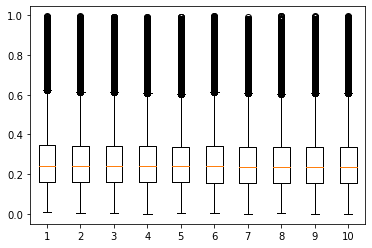

In [18]:
fig,ax = plt.subplots()
data = []
for i in range(10):
    data.append([x for x in temp_me_tox.T[i] if str(x)!="nan"])
ax.boxplot(data)
plt.show()

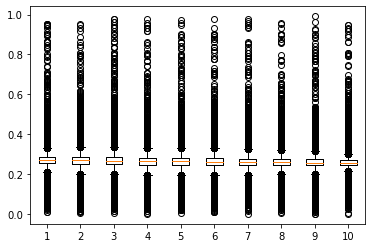

In [19]:
fig,ax = plt.subplots()
data = []
for i in range(10):
    data.append([x for x in temp_env_tox.T[i] if str(x)!="nan"])
ax.boxplot(data)
plt.show()

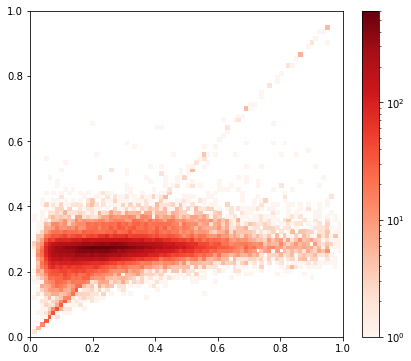

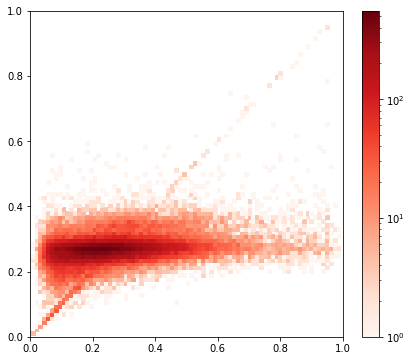

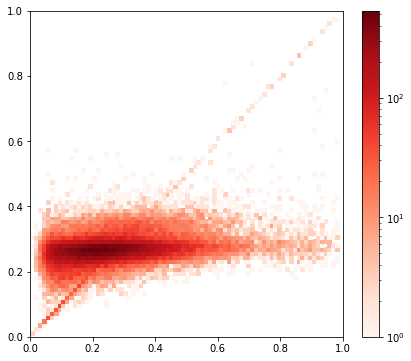

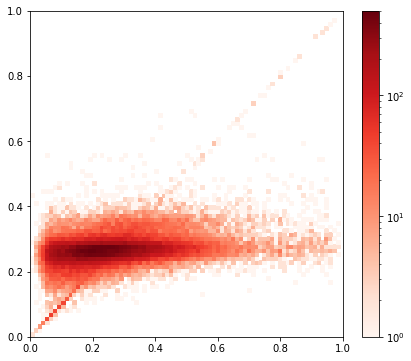

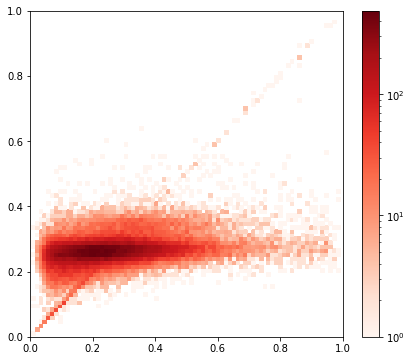

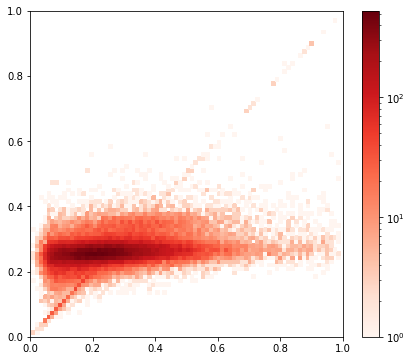

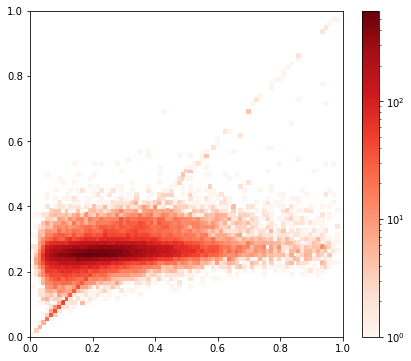

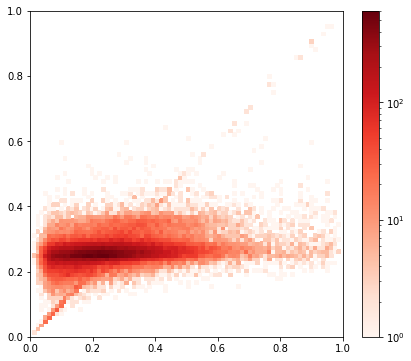

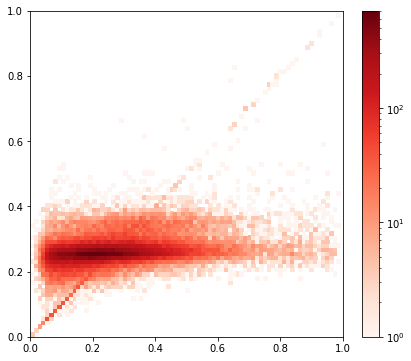

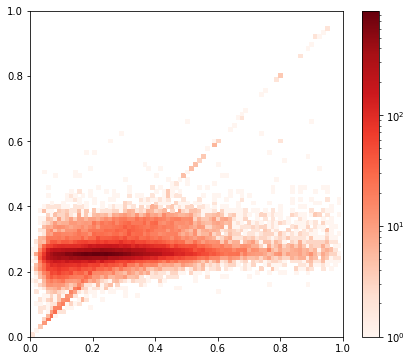

In [35]:
import matplotlib as mpl
for i in range(10):
    fig,ax = plt.subplots(figsize=(7,6))
    x = [t for t in temp_me_tox.T[i]]
    y = [t for t in temp_env_tox.T[i]]
    new_x = []
    new_y = []
    for a,b in zip(x,y):
        if str(a)!="nan" and str(b)!="nan":
            new_x.append(a)
            new_y.append(b)
#     plt.scatter(x,y, cmap="Reds", s=1, marker="+", color="#FF4500")
    plt.hist2d(new_x, new_y, (80,80), norm=mpl.colors.LogNorm(), cmap="Reds", cmin=1)
    plt.colorbar()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    plt.show()

In [27]:
# temp_me_tox
# temp_env_tox
# temp_gfp

In [23]:
temp_env_tox

array([[0.31118412, 0.3695324 , 0.40150626, ..., 0.30769162, 0.30419435,
        0.26203378],
       [0.28155677, 0.27421662, 0.25957218, ..., 0.26689191, 0.25737638,
        0.26926334],
       [0.34939717, 0.34381373, 0.35878975, ..., 0.36154679, 0.37554329,
        0.36235056],
       ...,
       [0.25351047, 0.25420289, 0.26905494, ..., 0.31383944, 0.27701309,
        0.27218896],
       [0.24235706, 0.30258819, 0.27341044, ..., 0.24974707, 0.25501996,
        0.20589766],
       [0.21835268, 0.22573266, 0.21302229, ..., 0.25132223, 0.25936972,
        0.2200558 ]])

In [24]:
temp_gfp

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 1., 0., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 0., 1., 0.]])

<ErrorbarContainer object of 3 artists>

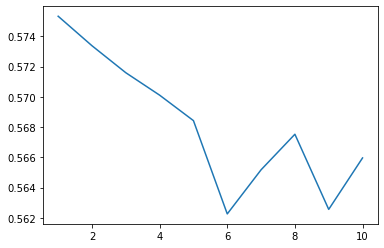

In [29]:
plt.errorbar(x=np.arange(1,11), 
             y=np.mean(temp_gfp, axis=0),
#              yerr=np.std(temp_gfp, axis=0)
            )

## temporal GFP

In [ ]:
# for each user, examine whether GFP hold true through 10 timepoints in their lifetime

In [15]:
utc2datetime(1325384477)

datetime.datetime(2012, 1, 1, 2, 21, 17)

## misc

In [ ]:
# created time of submissions
SUBM_TIME = dfall[dfall["comment_id"].isna()][["submission_id","created_utc"]]
SUBM_TIME = SUBM_TIME.reset_index().drop(columns=["index"])  # 751577

In [ ]:
# last reply time of submissions
SUBM_TIME2 = dfall[dfall["comment_id"].notna()][["submission_id","created_utc"]].groupby("submission_id").max()
SUBM_TIME2 = SUBM_TIME2.reset_index().rename(columns={"created_utc":"last_utc"})
SUBM_TIME = SUBM_TIME.merge(SUBM_TIME2, on="submission_id", how="left")
# SUBM_TIME["last_utc"] = SUBM_TIME["last_utc"].map(lambda x: int(x) if str(x) != "nan" else np.NaN)
SUBM_TIME_DICT = SUBM_TIME.set_index("submission_id").to_dict()